# Cheminformatics Project: Predicting Aqueous Solubility using Linear Regression

Cheminformatics is an exciting field that combines Chemistry with Informatics by collecting, storing, analysing and manipulating chemical data. Cheminformatics originally emerged to aid and inform drug discovery, however it has now grown to involve important areas of biology, chemistry and biochemistry, with many similarities to the field of bioinformatics. Aqueous solubility is one of the key physical properties of interest to a medicinal chemist as it affects the uptake/distribution of biologically active compounds within the body.

In this project we will first try to replicate, and then improve upon, research by John S. Delaney [1], who used linear regression to predict the aqueous solubility (ESOL) of a range of molecules. Delaney demonstrates that you can predict the solubility to a reasonable accuracy using 4 easily observable parameters: molecular weight, number of rotatable bonds, aromatic proportion and the octane-water partition coefficient.

It is worth noting that in his algorithm, Delaney uses 2874 molecules for training, however his supporting information only provides us with 1128.

Finally, I would like to thank Prof. Jan H. Jensen [2] for the idea for this notebook and for his excellent tutorials on the use of machine learning within chemistry.

## Contents

**Libraries**

**1.0 Reproducing Delaney's Results**
1.1 Data Creation + Preprocessing
1.2 Data Analysis
1.3 Models
1.3.1 Homemade Linear Regression
1.3.2 sklearn Linear Regression
1.4 Evaluation

**2.0 Improving upon Delaney's Results**
2.1 Additional Data Creation + Preprocessing
2.2 Additional Data Analysis
2.3 Model
2.4 Evaluation
2.4.1 Using Delaney Dataset
2.4.2 Using Yalkowsky Dataset
2.4.3 Comparison of All Models
2.5 Conclusion

**References**

**Libraries**

In [129]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from homebuilt_linear_regression import *

from rdkit.Chem import PandasTools, Descriptors, rdMolDescriptors

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [130]:
np.random.seed(1)

## 1.0 Reproducing Delaney's Results

### 1.1 Data Creation + Preprocessing

**Importing Delaney's Dataset**

The data used in Delany's regression can be found in his paper's [supporting information](https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt) as a csv. However, it is also possible to generate all of these parameters using the python cheminformatics library, RDKit. RDKit focuses around representing molecules as SMILE strings (Simplified Molecular-Input Line-Entry System).

In [131]:
# !python -m wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

In [132]:
df = pd.read_csv('delaney-processed.csv', usecols=['Compound ID', 'smiles', 'ESOL predicted log solubility in mols per litre', 'measured log solubility in mols per litre'])
df = df.rename(columns={'Compound ID':'Name',
                        'ESOL predicted log solubility in mols per litre':'ESOL Predicted log(solubility/M)',
                        'measured log solubility in mols per litre':'Measured log(solubility/M)'})
df.head()

,Name,ESOL Predicted log(solubility/M),Measured log(solubility/M),smiles
0,Amigdalin,-0.974,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,-1.33,c1ccsc1


Molar (M) is an equivalant unit to mols per litre (or dm$^{3}$).

**Deriving Inputs from RDKit**

Using the SMILE strings provided we will create an RDKit object for each molecule. This then allows us to generate all of the parameters we'll need with just a few lines of code. This is the essence of Delaney's paper, providing a way to predict solubility values using only easily generated parameters.

In [133]:
# Type: rdkit.Chem.rdchem.Mol, displayed as an image in df
PandasTools.AddMoleculeColumnToFrame(df, 'smiles', 'Molecule')

In [134]:
def aromatic_proportion(mol):
    
    aromatic_atoms = [mol.GetAtomWithIdx(i).GetIsAromatic() for i in range(mol.GetNumAtoms())] #returns bool for each atom
    aromatic_count = sum(aromatic_atoms)
    heavy = Descriptors.HeavyAtomCount(mol)
    
    return aromatic_count / heavy

In [135]:
# molecular weight
mw_lst = [ Descriptors.MolWt(element) for element in df.Molecule ]
df['MW'] = np.array(mw_lst)

# number of rotatable bonds
rb_lst = [ Descriptors.NumRotatableBonds(element) for element in df.Molecule ]
df['RB'] = np.array(rb_lst)

# aromatic proportion 
ap_lst = [ aromatic_proportion(element) for element in df.Molecule ]
df['AP'] = np.array(ap_lst)

# octane-water partition coefficient
cLogP_lst = [ Descriptors.MolLogP(element) for element in df.Molecule ]
df['cLogP'] = np.array(cLogP_lst)

In [136]:
df.head()

,Name,ESOL Predicted log(solubility/M),Measured log(solubility/M),smiles,Molecule,MW,RB,AP,cLogP
0,Amigdalin,-0.974,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x000002052BB...,457.432,7,0.187500,-3.10802
1,Fenfuram,-2.885,-3.30,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x000002052BB...,201.225,2,0.733333,2.84032
2,citral,-2.579,-2.06,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x000002052BB...,152.237,4,0.000000,2.87800
3,Picene,-6.618,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x000002052BB...,278.354,0,1.000000,6.29940
4,Thiophene,-2.232,-1.33,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x000002052BB...,84.143,0,1.000000,1.74810


We now have all of the training data needed to replicate Delaney's results.

### 1.2 Data Analysis

In [137]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ESOL Predicted log(solubility/M),1128.0,-2.988192,1.683220,-9.7020,-3.94825,-2.870,-1.843750,1.0910
Measured log(solubility/M),1128.0,-3.050102,2.096441,-11.6000,-4.31750,-2.860,-1.600000,1.5800
MW,1128.0,203.937074,102.738077,16.0430,121.18300,182.179,270.372000,780.9490
RB,1128.0,2.177305,2.640974,0.0000,0.00000,1.000,3.000000,23.0000
AP,1128.0,0.363544,0.343778,0.0000,0.00000,0.375,0.666667,1.0000
cLogP,1128.0,2.447520,1.852875,-7.5714,1.41490,2.339,3.402200,10.3886


Histograms and scatter plots for each parameter are given below to give an overview of the characteristics of the molecules in the dataset.

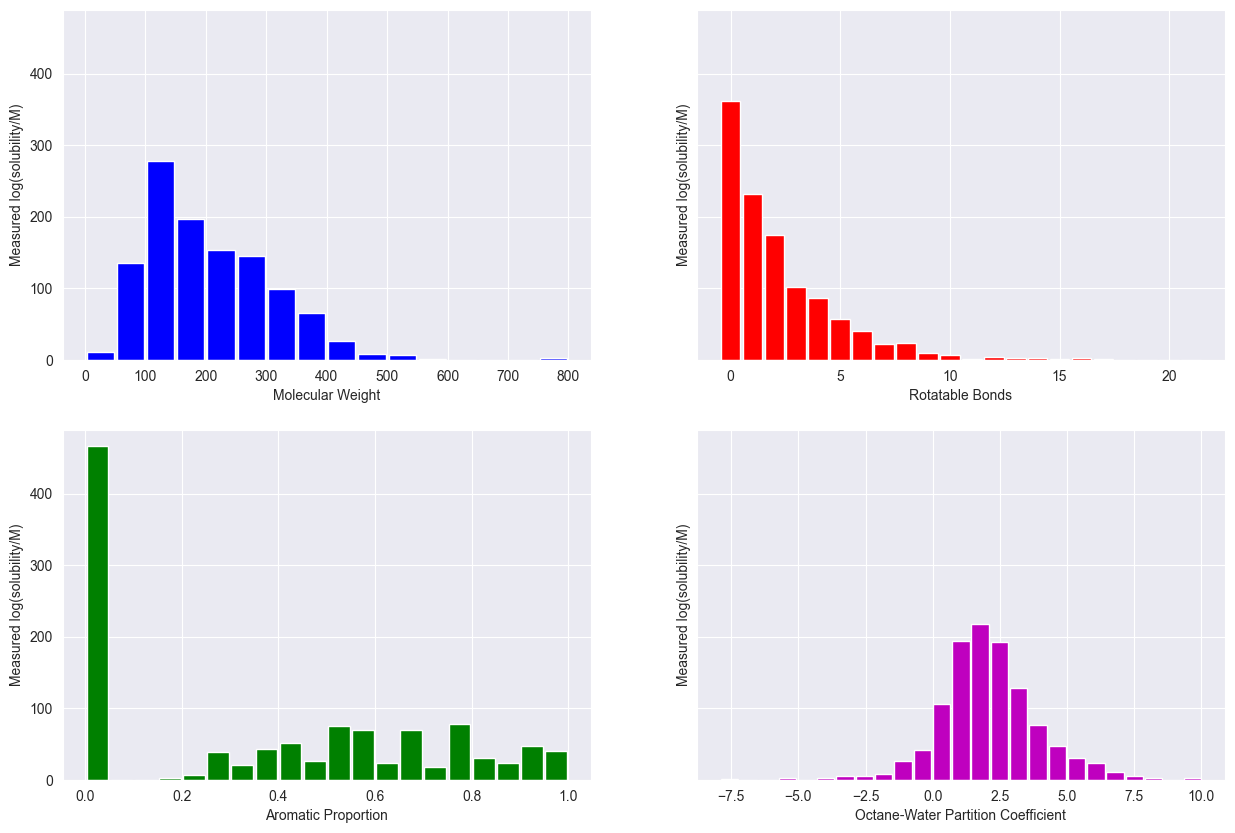

In [138]:
# histograms of each variable and the measured log solubility
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharey=True)

ax1 = ax[0,0]
ax1.hist(df['MW'], bins=[i for i in range(0,850,50)], rwidth=0.9, color='b') # split into every ~50
ax1.set_xlabel('Molecular Weight')
ax1.set_ylabel('Measured log(solubility/M)')

ax2 = ax[0,1]
ax2.hist(df['RB'], bins=[i for i in range(23)], align='left', rwidth=0.9, color='r') # bin for each int
ax2.set_xlabel('Rotatable Bonds')
ax2.set_ylabel('Measured log(solubility/M)')

ax3 = ax[1,0]
ax3.hist(df['AP'], bins=20, rwidth=0.9, color='g') # bin ofr each 0.1
ax3.set_xlabel('Aromatic Proportion')
ax3.set_ylabel('Measured log(solubility/M)')

ax4 = ax[1,1]
ax4.hist(df['cLogP'], bins=25, align='left', rwidth=0.9, color='m')
ax4.set_xlabel('Octane-Water Partition Coefficient')
ax4.set_ylabel('Measured log(solubility/M)')

plt.show()

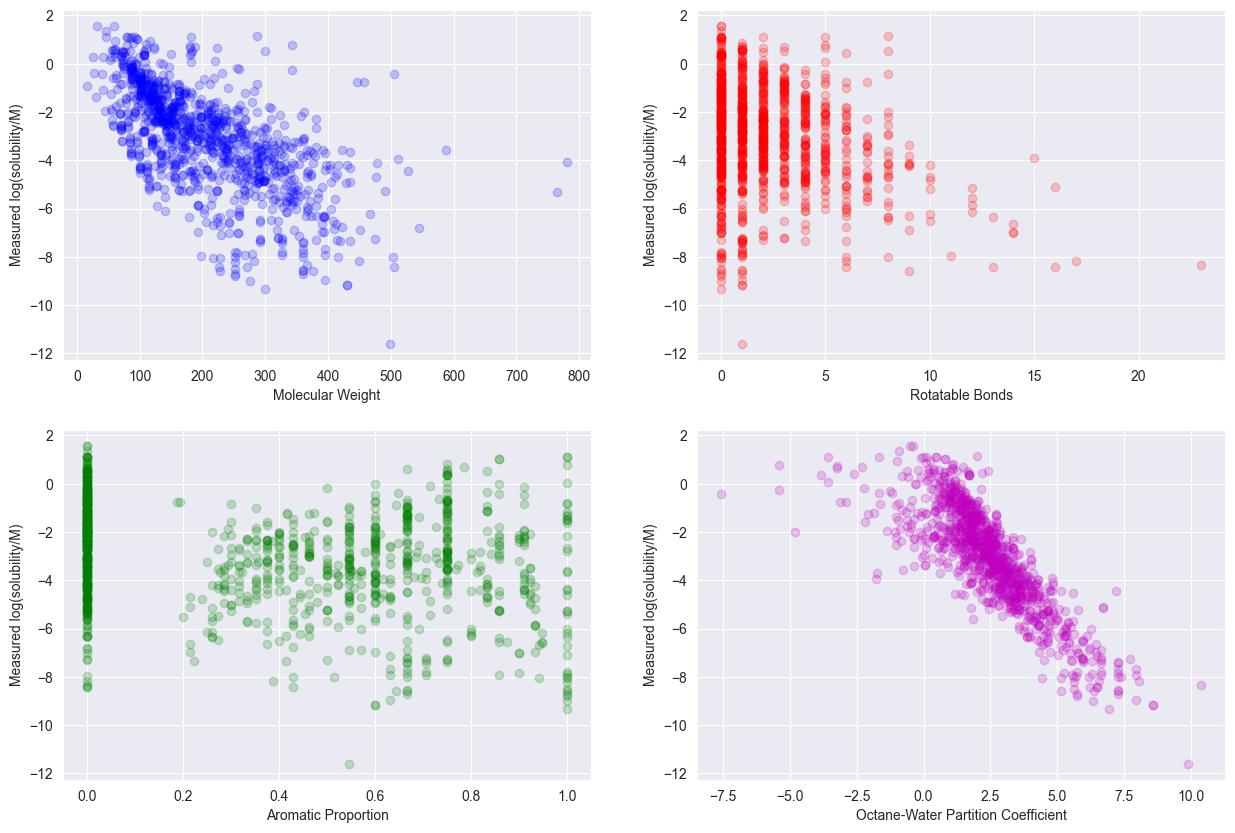

In [139]:
# scatter plot for each variable and the log solubility
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax1 = ax[0,0]
ax1.scatter(df['MW'], df['Measured log(solubility/M)'], c='b', alpha=0.2)
ax1.set_xlabel('Molecular Weight')
ax1.set_ylabel('Measured log(solubility/M)')

ax2 = ax[0,1]
ax2.scatter(df['RB'], df['Measured log(solubility/M)'], c='r', alpha=0.2)
ax2.set_xlabel('Rotatable Bonds')
ax2.set_ylabel('Measured log(solubility/M)')

ax3 = ax[1,0]
ax3.scatter(df['AP'], df['Measured log(solubility/M)'], c='g', alpha=0.2)
ax3.set_xlabel('Aromatic Proportion')
ax3.set_ylabel('Measured log(solubility/M)')

ax4 = ax[1,1]
ax4.scatter(df['cLogP'], df['Measured log(solubility/M)'], c='m', alpha=0.2)
ax4.set_xlabel('Octane-Water Partition Coefficient')
ax4.set_ylabel('Measured log(solubility/M)')

plt.show()

Even before training our algorithm we can see that the octane-water partition coefficient is likely to be an important factor in the regression as it has a clear linear correlation.

### 1.3 Models

In [140]:
X = df[['MW', 'RB', 'AP', 'cLogP']]

Y = df['Measured log(solubility/M)']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

**1.3.1 Homebuilt Linear Regression**

The first model we will test is a homebuilt linear regression which can be found in the homebuilt_linear_regression.py script. Building your own algorithm from scratch is a great way to understand the mathematics behind it.

epoch     mse
0         12057.091406983527
100000    1.1287554857531101
200000    1.0623293539159244
300000    1.034007852644773
400000    1.0216878279839743
500000    1.0161614130126928
600000    1.0135680523588937
700000    1.0122751806252974
800000    1.0115825001704317
900000    1.0111826369389205


Weights
Intercept                     0.17296023141958838
MW                           -0.006394807728179437
RB                           -0.005648669041778065
AP                           -0.31994705685682595
cLogP                        -0.7344151087045656


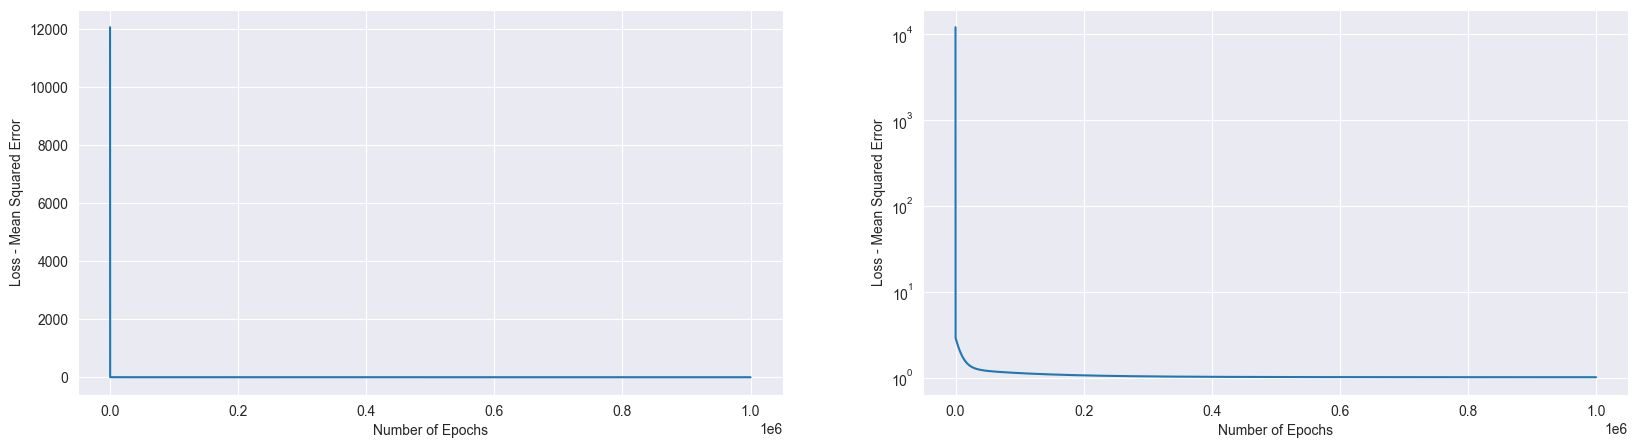

1.0109358383603433


In [141]:
weights, loss_func = multi_linear_regression_train(X_train, Y_train, epochs=1_000_000, learning_rate=0.00002)

plot_loss(loss_func)

print(f'The final MSE value is {loss_func[-1]}')

In [142]:
mse, mae, r2 = multi_linear_regression_test(X_test, Y_test, w=weights)
print(f'Mean absolute error (MAE): {mae:.4f}')
print(f'Mean squared error (MSE): {mse:.4f}')
print(f'Coefficient of determination (R^2): {r2:.4f}')

Mean absolute error (MAE): 0.7925
Mean squared error (MSE): 1.0476
Coefficient of determination (R^2): 0.7663


In [143]:
Delaney_homebuilt = { 'model':'homebuilt',
                      'mse':mse,
                      'mae':mae,
                      'r2':r2,
                      'intercept':weights[0,0],
                      'MW':weights[0,1],
                      'RB':weights[0,2],
                      'AP':weights[0,3],
                      'cLogP':weights[0,4] }
# will use lst of dicts for pd.DataFrame

**1.3.2 sklearn Linear Regression**

In [145]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [146]:
Y_pred_test = model.predict(X_test)

In [147]:
print(f'Mean absolute error (MAE): {mean_absolute_error(Y_test, Y_pred_test):.4f}')
print(f'Mean squared error (MSE): {mean_squared_error(Y_test, Y_pred_test):.4f}')
print(f'Coefficient of determination (R^2): {r2_score(Y_test, Y_pred_test):.4f}')

Mean absolute error (MAE): 0.7892
Mean squared error (MSE): 1.0447
Coefficient of determination (R^2): 0.7669


In [148]:
Delaney_sklearn = { 'model':'sklearn_basic',
                      'mse':mean_squared_error(Y_test, Y_pred_test),
                      'mae':mean_absolute_error(Y_test, Y_pred_test),
                      'r2':r2_score(Y_test, Y_pred_test),
                      'intercept':model.intercept_,
                      'MW':model.coef_[0],
                      'RB':model.coef_[1],
                      'AP':model.coef_[2],
                      'cLogP':model.coef_[3] }

### 1.4 Evaluation

In [149]:
# calculate delaney's stats
delaney_error = df['Measured log(solubility/M)']-df['ESOL Predicted log(solubility/M)']
d_mse = np.mean(delaney_error**2)
d_mae = np.mean(abs(delaney_error))

diff = df['Measured log(solubility/M)']-df['ESOL Predicted log(solubility/M)'].mean()
d_r2 = 1 - (np.sum(delaney_error**2)/np.sum(diff**2))

Delaney_literature = {'model':'literature',
                      'mse':d_mse,
                      'mae':d_mae,
                      'r2':d_r2,
                      'intercept':0.16,
                      'MW':-0.0062,
                      'RB':0.066,
                      'AP':-0.74,
                      'cLogP':-0.63 }

In [172]:
results = pd.DataFrame([Delaney_literature, Delaney_homebuilt, Delaney_sklearn]).set_index('model')
results

,mse,mae,r2,intercept,MW,RB,AP,cLogP
model,,,,,,,,
literature,0.828341,0.697862,0.811527,0.160000,-0.006200,0.066000,-0.740000,-0.630000
homebuilt,1.047624,0.792461,0.766254,0.172960,-0.006395,-0.005649,-0.319947,-0.734415
sklearn_basic,1.044663,0.789245,0.766915,0.216849,-0.006455,-0.009243,-0.384451,-0.732438


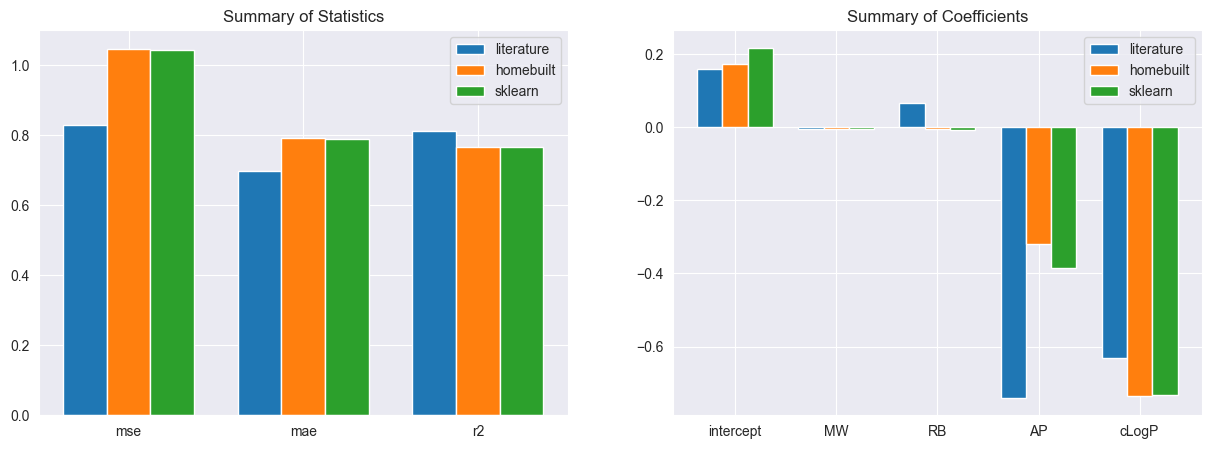

In [173]:
# Plot of a summary of the three models
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
width = 0.25

# summary of statistics
ax1 = ax[0]

X = results.columns[:3]
X_axis = np.arange(len(X))

ax1.bar(X_axis-width, results.loc['literature'][:3], width=width, label = 'literature')
ax1.bar(X_axis, results.loc['homebuilt'][:3], width=width, label = 'homebuilt')
ax1.bar(X_axis+width, results.loc['sklearn_basic'][:3], width=width, label = 'sklearn')

ax1.set_xticks(X_axis, X)
ax1.set_title("Summary of Statistics")
ax1.legend()

# summary of coefficients
ax2 = ax[1]

X = results.columns[3:]
X_axis = np.arange(len(X))

ax2.bar(X_axis-width, results.loc['literature'][3:], width=width, label = 'literature')
ax2.bar(X_axis, results.loc['homebuilt'][3:], width=width, label = 'homebuilt')
ax2.bar(X_axis+width, results.loc['sklearn_basic'][3:], width=width, label = 'sklearn')

ax2.set_xticks(X_axis, X)
ax2.set_title("Summary of Coefficients")
ax2.legend()

plt.show()

- sklearn regression is only marginally better than a homebuilt one. I find this quite surprising.
- Delaney's model is significantly more accurate for across all indicators.
- 2 major distinctions in terms of coefficients: Delaney gives significantly more importance to aromatic proportion giving it the most weight out of all predictors, number of rotatable bonds is an order of magnitude higher is delaney's AND the opposite sign.
- these deviations can be explained partially by the difference in training set size. Delaney had 2874 molecules, whereas we only have 1128.

## 2.0 Improving upon Delaney's Results

We shall now try to optimise our linear regression to see if we can improve on it's accuaracy and perhaps even beat Delaney's model.

### 2.1 Additional Data Creation + Preprocessing

One simple way to improve a linear regression is to add more parameters (up to a certain point). We will try adding 3 more descriptors using RDKit: number of rings, number of H bond donors and the topological polar surface area.

In [163]:
# number of rings
rings_lst = [ rdMolDescriptors.CalcNumRings(element) for element in df.Molecule ]
df['RINGS'] = np.array(rings_lst)

# number of H bond donors
hbd_lst = [ rdMolDescriptors.CalcNumHBD(element) for element in df.Molecule ]
df['HBD'] = np.array(hbd_lst)

# topological polar surface area
psa_lst = [ Descriptors.TPSA(element) for element in df.Molecule ]
df['PSA'] = np.array(psa_lst)

## 2.2 Additional Data Analysis

In [164]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ESOL Predicted log(solubility/M),1128.0,-2.988192,1.683220,-9.7020,-3.94825,-2.870,-1.843750,1.0910
Measured log(solubility/M),1128.0,-3.050102,2.096441,-11.6000,-4.31750,-2.860,-1.600000,1.5800
MW,1128.0,203.937074,102.738077,16.0430,121.18300,182.179,270.372000,780.9490
RB,1128.0,2.177305,2.640974,0.0000,0.00000,1.000,3.000000,23.0000
AP,1128.0,0.363544,0.343778,0.0000,0.00000,0.375,0.666667,1.0000
cLogP,1128.0,2.447520,1.852875,-7.5714,1.41490,2.339,3.402200,10.3886
RINGS,1128.0,1.390957,1.318286,0.0000,0.00000,1.000,2.000000,8.0000
HBD,1128.0,0.701241,1.089727,0.0000,0.00000,0.000,1.000000,11.0000
PSA,1128.0,34.872881,35.383593,0.0000,0.00000,26.300,55.440000,268.6800


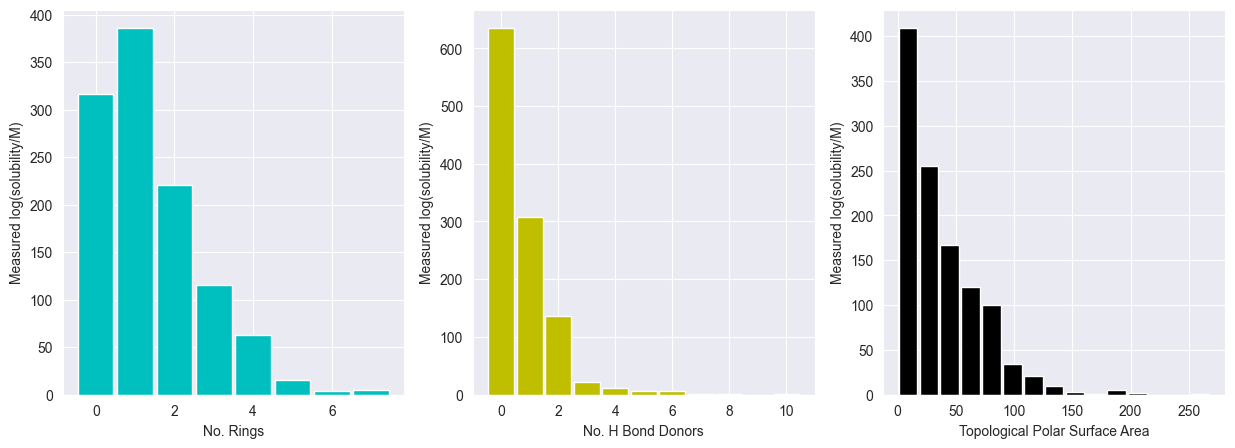

In [154]:
# histograms of each variable and the log solubility
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax1 = ax[0]
ax1.hist(df['RINGS'], bins=8, align='left', rwidth=0.9, color='c')
ax1.set_xlabel('No. Rings')
ax1.set_ylabel('Measured log(solubility/M)')

ax2 = ax[1]
ax2.hist(df['HBD'], bins=11, align='left', rwidth=0.9, color='y')
ax2.set_xlabel('No. H Bond Donors')
ax2.set_ylabel('Measured log(solubility/M)')

ax3 = ax[2]
ax3.hist(df['PSA'], bins=15, rwidth=0.9, color='k')
ax3.set_xlabel('Topological Polar Surface Area')
ax3.set_ylabel('Measured log(solubility/M)')

plt.show()

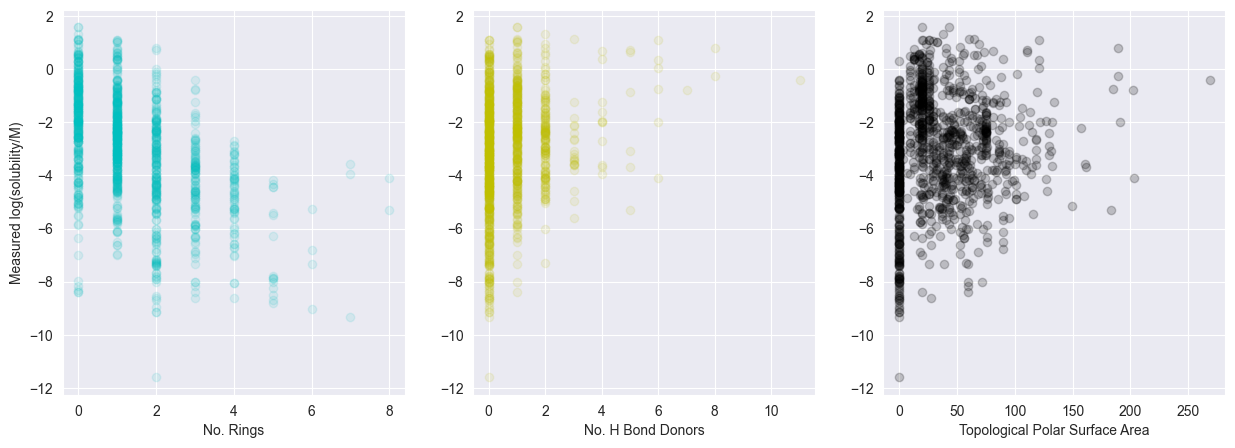

In [155]:
# scatter plot for each variable and the log solubility
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax1 = ax[0]
ax1.scatter(df['RINGS'], df['Measured log(solubility/M)'], c='c', alpha=0.1)
ax1.set_xlabel('No. Rings')
ax1.set_ylabel('Measured log(solubility/M)')

ax2 = ax[1]
ax2.scatter(df['HBD'], df['Measured log(solubility/M)'], c='y', alpha=0.1)
ax2.set_xlabel('No. H Bond Donors')

ax3 = ax[2]
ax3.scatter(df['PSA'], df['Measured log(solubility/M)'], c='k', alpha=0.2)
ax3.set_xlabel('Topological Polar Surface Area')

plt.show()

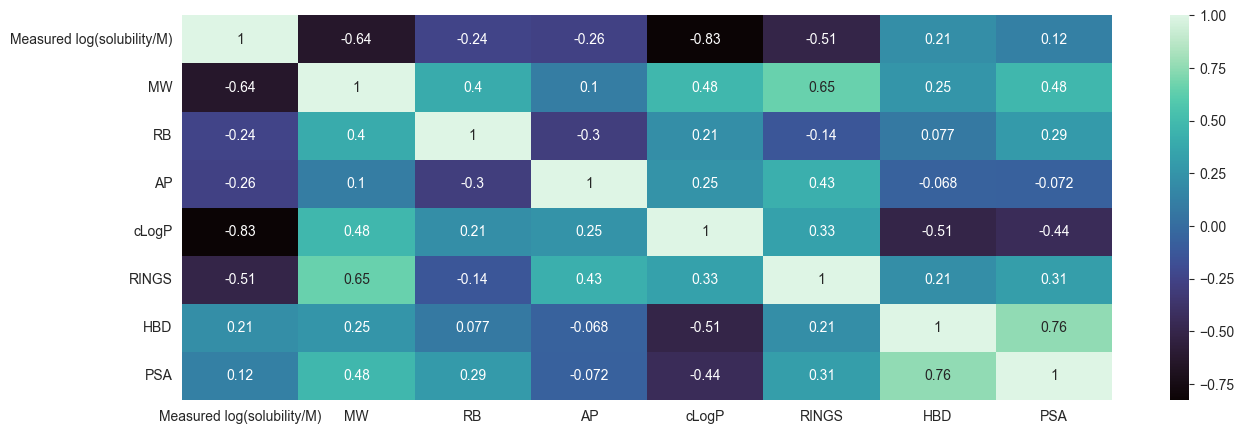

In [156]:
# correlation table
corr = df[['Measured log(solubility/M)', 'MW', 'RB', 'AP', 'cLogP', 'RINGS', 'HBD', 'PSA']].corr()
plt.figure(figsize=(15,5))
sns.heatmap(corr, cmap='mako', annot=True)
plt.show()

This demonstrates why cLogP is given the most weight within the linear regression, as it has an absolute correlation of 0.83. However, this is not true for all variables, for example molecular weight has the second highest absolute correlation but the lowest weight coefficient in the model.

### 2.3 Model

In [157]:
X = df[['MW', 'RB', 'AP', 'cLogP', 'RINGS', 'HBD', 'PSA']]

Y = df['Measured log(solubility/M)']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [158]:
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred_test = model.predict(X_test)

In [166]:
print(f'Mean absolute error (MAE): {mean_absolute_error(Y_test, Y_pred_test):.4f}')
print(f'Mean squared error (MSE): {mean_squared_error(Y_test, Y_pred_test):.4f}')
print(f'Coefficient of determination (R^2): {r2_score(Y_test, Y_pred_test):.4f}')

Mean absolute error (MAE): 0.7611
Mean squared error (MSE): 0.9324
Coefficient of determination (R^2): 0.8033


In [167]:
improved_sklearn = { 'model':'sklearn_improved',
                    'mse':mean_squared_error(Y_test, Y_pred_test),
                    'mae':mean_absolute_error(Y_test, Y_pred_test),
                    'r2':r2_score(Y_test, Y_pred_test),
                    'intercept':model.intercept_,
                    'MW':model.coef_[0],
                    'RB':model.coef_[1],
                    'AP':model.coef_[2],
                    'cLogP':model.coef_[3],
                    'RINGS':model.coef_[4],
                    'HBD':model.coef_[5],
                    'PSA':model.coef_[6]}

In [174]:
results = pd.DataFrame([Delaney_literature, Delaney_homebuilt, Delaney_sklearn, improved_sklearn]).set_index('model')
results

,mse,mae,r2,intercept,MW,RB,AP,cLogP,RINGS,HBD,PSA
model,,,,,,,,,,,
literature,0.828341,0.697862,0.811527,0.160000,-0.006200,0.066000,-0.740000,-0.630000,NaN,NaN,NaN
homebuilt,1.047624,0.792461,0.766254,0.172960,-0.006395,-0.005649,-0.319947,-0.734415,NaN,NaN,NaN
sklearn_basic,1.044663,0.789245,0.766915,0.216849,-0.006455,-0.009243,-0.384451,-0.732438,NaN,NaN,NaN
sklearn_improved,0.932376,0.761148,0.803269,0.209899,-0.002559,-0.030727,-0.113880,-0.859138,-0.232132,-0.190968,-0.002227


As you can see this immediately reduces both the MSE (by 11%) and the MAE (by 4%). This also further increases the models reliance on the octane-water partition coefficient and reduces the reliance on aromatic proportion, moving further away from Delaney's coefficients.

This can be partially explained by the inclusion of the number of rings as a parameter. Most rings will be aromatic and so rings and AP will be correlated to some degree. In fact, if you add together the coefficients for rings and aromatic proportion you get a value very close to that of the aromatic proportion coefficient for previous models.

A second way to improve results is to use k fold cross validation. The cell below tests several different k values to find the one with the greatest accuracy.

Ideal: 0.840
> folds=2, accuracy=0.740 (0.700,0.780)
> folds=3, accuracy=0.749 (0.697,0.824)
> folds=4, accuracy=0.790 (0.640,0.920)
> folds=5, accuracy=0.810 (0.600,0.950)
> folds=6, accuracy=0.820 (0.688,0.941)
> folds=7, accuracy=0.799 (0.571,1.000)
> folds=8, accuracy=0.811 (0.385,0.923)
> folds=9, accuracy=0.829 (0.636,1.000)
> folds=10, accuracy=0.850 (0.600,1.000)
> folds=11, accuracy=0.829 (0.667,1.000)
> folds=12, accuracy=0.785 (0.250,1.000)
> folds=13, accuracy=0.839 (0.571,1.000)
> folds=14, accuracy=0.807 (0.429,1.000)
> folds=15, accuracy=0.821 (0.571,1.000)
> folds=16, accuracy=0.827 (0.500,1.000)
> folds=17, accuracy=0.816 (0.600,1.000)
> folds=18, accuracy=0.831 (0.600,1.000)
> folds=19, accuracy=0.826 (0.600,1.000)
> folds=20, accuracy=0.830 (0.600,1.000)
> folds=21, accuracy=0.814 (0.500,1.000)
> folds=22, accuracy=0.820 (0.500,1.000)
> folds=23, accuracy=0.802 (0.250,1.000)
> folds=24, accuracy=0.804 (0.250,1.000)
> folds=25, accuracy=0.810 (0.250,1.000)
> folds=26,

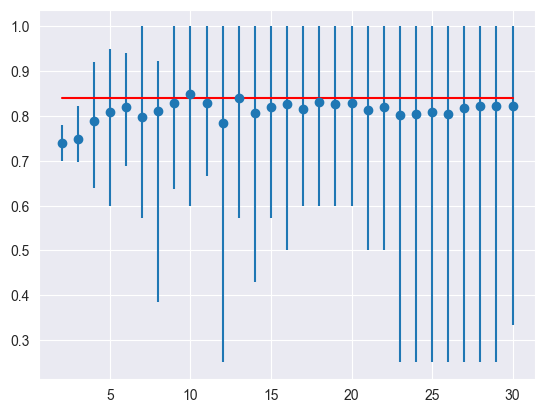

In [162]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score
from matplotlib import pyplot as plt
 
# create the dataset
def get_dataset(n_samples=100):
    X, y = make_classification(n_samples=n_samples, n_features=20, n_informative=15, n_redundant=5, random_state=1)
    return X, y
 
# retrieve the model to be evaluate
def get_model():
    model = LogisticRegression()
    return model
 
# evaluate the model using a given test condition
def evaluate_model(cv):
    # get the dataset
    X, y = get_dataset()
    # get the model
    model = get_model()
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return np.mean(scores), scores.min(), scores.max()
 
# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,31)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
    # define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    # evaluate k value
    k_mean, k_min, k_max = evaluate_model(cv)
    # report performance
    print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
    # store mean accuracy
    means.append(k_mean)
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
plt.show()

### 2.4 Evaluation

### 2.5 Conclusion

ESOL is really useful, particularly for developing new molecules. This is because the most widely used model for predicting aqueous solubility, the General Solubility Equation (GSE) relies on knowing the melting temperature of a molecule. While melting temperature can be measured for existing molecules, predicting it for *de novo* molecules is notoriously tricky and computationally expensive.

# References

1. [ESOL: Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x), J. S. Delany, J. Chem. Inf. Comput. Sci. 2004, **44**, 1000-1005
2. [Machine Learning Basics by Jan H. Jensen](https://sites.google.com/view/ml-basics/home?authuser=0)